In [1]:
import pandas as pd
import numpy as np
import datetime
import copy
import math

In [2]:
import seaborn as sns
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates

# Transformation Phase
- load data of 12 valid sector indexs from the stock market

In [3]:
def loadDate():
    file1 = u"E:/工作/1.0_项目/7.5.智能投顾_RAIS3/Data/Data Source/rais030_data.csv"
    initData = pd.DataFrame()
    colnames = [u'market_date', u'ep_index', u'pharma_index', u'bank_index',
                u'ind4_index', u'tmt_index', u'comsum_index', u'media_index',
                u'secur_index', u're_index', u'coal_index', u'nofer_index',
                u'it_index',u'hs300_index']
    initData = pd.read_csv(file1, na_values=['na']) #, names = colnames
    #initData.columns
    return  initData

- calculate annual return

In [4]:
def annual_return(lag, index_ret):
    ret_y = (1+ index_ret)**(240/lag) - 1
    return ret_y
#secData["hs300_index"][50:]/secData["hs300_index"].shift(50)[50:]

- calculate Beta Ratio

In [5]:
def calBeta(index_ret, benchmark_ret):
    #df = pd.DataFrame({"market_date":date_line,"index_ret":index_ret, "benchmark_ret":benchmark_ret})
    beta = index_ret.rolling(50, min_periods = 25).cov(benchmark_ret)/ \
           index_ret.rolling(50, min_periods = 25).var()
    return beta    

- calculate Alpha ratio
- risk-free rate is defined temporarily as 0.039

In [6]:
def calAlpha(freq, index_ret, benchmark_ret, rf=0.039):
    benchRet_y = annual_return(freq, benchmark_ret)
    indexRet_y = annual_return(freq, index_ret)
    beta = calBeta(index_ret, benchmark_ret)
    alpha = (indexRet_y- rf) - beta*(benchRet_y -rf)
    return alpha

- judge which sector has a significant trend

In [7]:
def mineSec(Alpha, threshold_up = 0.1,threshold_down = -0.1): 
    secClass = Alpha.copy()
    secClass.iloc[:,:] = 0 #OR: clfy_sec[~np.isnan(clfy_sec)] = 0
    for i in range(len(Alpha)):
        occur_d = Alpha.iloc[i,:]
        #表现优于市场的前三个行业
        which_gd = occur_d[occur_d > threshold_up].sort_values(ascending = False).index#[:3]#可能小于3个
        secClass.loc[secClass.index[i],which_gd] = 1
        #表现劣于市场的前三个行业
        which_bd = occur_d[occur_d < threshold_down].sort_values(ascending = False).index#[:3]#可能小于3个
        secClass.loc[secClass.index[i],which_bd] = -1
    return secClass 

- for vertification

In [8]:
def aggregate(sec_class):
    Strong = sec_class[sec_class == 1].count()#secClass.iloc[1][secClass.iloc[1] == 1]
    Weak = sec_class[sec_class == -1].count()
    Consol = sec_class[sec_class == 0].count()
    #a.append([Strong, Weak, Consol])
    return [Strong, Weak, Consol]

- identify the meaning of Transformation Coding

In [9]:
def getMarketStatList(marketStatList, classTitleList):
    itemMeaning = []
    for classTitle in classTitleList:
        itemMeaning.append("{} - Up".format(classTitle))
        itemMeaning.append("{} - Down".format(classTitle))
    marketDict = {}
    for marketDate in marketStatList.index:#row
        sectorList = marketStatList.loc[marketDate,:]
        count = 0
        marketDict[str(marketDate)[:10]] = []
        for sector in sectorList:#column
            if sector == 1:
                marketDict[str(marketDate)[:10]].append(count)
            elif sector == -1:
                marketDict[str(marketDate)[:10]].append(count+1)
            count += 2
    return marketDict, itemMeaning

#  Main Part1

In [10]:
secData = loadDate()
secData['market_date'] = pd.to_datetime(secData['market_date'], format='%Y/%m/%d')
secData.sort_values(by='market_date', inplace = True)
secData.iloc[:,1:] = secData.iloc[:, 1:].astype('float')
secData.drop_duplicates(['market_date'], inplace = True)
secData.set_index('market_date', inplace = True)
#周收益
secData_wret = secData.resample('W').last().pct_change().copy() 
#累计收益
secData_cumret = (secData_wret + 1).cumprod().copy()
#secData.resample('W', how = lambda x: (1.0+x).cumprod() - 1.0)
secData_wret.iloc[0] = 0.0
secData_cumret.iloc[0] = 1.0
secData_wret.dropna(how = 'any', inplace = True)
secData_cumret.dropna(how = 'any', inplace = True)

#Input 1:----------------------------------------------------------------------------------------
rf = 0.039 #10-year Treasury Bond rate
freq = 5 #影响
threshold_up = 0.1 #行业表现明显上升趋势的阈值
threshold_down = -0.1 #行业表现明显下降趋势的阈值
#-------------------------------------------------------------------------------------------

index_ret = secData_wret.loc[:,secData.columns != "hs300_index"]
benchmark_ret = secData_wret.iloc[:,-1] #沪深300
Abnormal_ret = lambda x: calAlpha(freq, x, benchmark_ret, rf)#计算Beta时丧失25条记录
secAlpha = index_ret.apply(Abnormal_ret, axis = 0).dropna(how = 'any') 
secClass = mineSec(secAlpha,threshold_up, threshold_down)
#查看每周涨、跌、盘整的行业数目
#agg_class = secClass.apply(aggregate, axis=1)

>>Experimemt:
    k = 0
    for key in sorted(marketDict.keys()):
        if k < 10:
            print marketDict[key]
            k += 1
        else:
            break

# Sort Phase

In [11]:
def SortPhase(marketDict, impactLag = 1):
    """
    Assume impact lag is 1 week, total Amount is 98, Pair Amount is 97
    将原weekly sequences 按影响滞后期（1、2、3、4）分别构建Pair-Sequences:
        e.g. Week1 {1,2,3,4}
             Week2 {2,3,4,7,8}   
             Week3 {1,4,8}
             ...
             Then assume the lag of sectors' impact is one week,
             transform them to below form:
             Week1 <{1,2,3,4},{2,3,4,7,8}>
             Week2 <{2,3,4,7,8},{1,4,8}>
             ...   
    """
    pairSet= [[] for i in range(len(marketDict) - 1)]
    k1 = 0
    k2 = 0
    for key in sorted(marketDict.keys())[:-impactLag]:
        pairSet[k1].append(list(marketDict[key]))
        k1 += 1
    for key in sorted(marketDict.keys())[impactLag:]:
        pairSet[k2].append(list(marketDict[key]))
        k2 += 1 
    #pairSet[row][column]
    return pairSet

In [12]:
def initPairSeq(pairSet,numPair,supRatio = 0.5): #Initialize
    """
        param:  pairSet  初始pair-sequence集
        result: temp     1-depth 频繁项集,i.e.初始频繁项集
                litemset 累计至1-depth的频繁项集,i.e.初始累计频繁项集
    """
    items = [] #每一个depth下的candidates
    for pairseq in pairSet:
        for itemset in pairseq:
            for item in itemset:
                if [item] not in items:
                    items.append([item])
                    
    UniqPair = lambda x,y: x if y in x else x+[y]
    temp = [] #当前depth下的频繁项集
    litemset = []#frequent litemset集合
    candidates = items
    for item1 in candidates:
        count = 0
        for pairSeq in pairSet:
            set1 = set(item1)
            uniqPair = []
            for itemset in pairSeq:
                for item in itemset:
                    uniqPair = UniqPair(uniqPair, item)
            if set1.issubset(uniqPair):
                count += 1
        if count >=  math.ceil(supRatio * numPair):   
            temp.append(item1)
            litemset.append(item1)
        #print "{}:{}".format(item1,count)
    return temp,litemset

# Litemset Phase
- Count Support 
- Find Litemsets

In [13]:
def countSup(pairSet, reList,numPair,supRatio = 0.5):#count support ， input:litemset
    """
        param:  reList   k-备选项集
                litemset <k的频繁项集（项集元素数少于当前depth）
                pairSet  配对后的原数据集
        result: temp     k-频繁项集
    """
    temp = []
    candidates = reList
    for item1 in candidates:
        count = 0
        flagSeq = True
        for pairSeq in pairSet:
            start = 0 
            for element in item1:
                flag = False
                for i in range(start,len(pairSeq)):
                    if set([element]).issubset(set(pairSeq[i])):
                        flag = True
                    start = i+1 #2
                    if flag == True:
                        break
            if flag == True:
                count += 1
        if count >= math.ceil(supRatio * numPair):
            temp.append(item1)
            #litemset.append(item1)
    return temp #, litemset

# Sequence Phase
- k-candidate generate
    - join

In [14]:
def candidateGen(Lk,k):#join
    """
        param:  Lk     k-1depth-频繁项集
                k      项集元素数/hash-tree's depth
        result: reList k-depth 备选项集
    """
    reList = []
    item = []
    lenLk = len(Lk)
    for i in range(lenLk):
        for j in range(lenLk):
            # i！= j:
            L1 = list(Lk[i])[:k-2]
            L2 = list(Lk[j])[:k-2]
            if L1==L2:
                item = copy.deepcopy(Lk[i])
                item.insert(len(Lk[i]),Lk[j][len(Lk[j])-1])
                reList.append(item) 
    return reList

> 如何引入多元素单元，e.g.｛1，2｝作为一个元素进行考量

- k-candidate generate
    - subsequence filter

In [15]:
def subseqFilter(reList, Lk, k):
    """
        params: reList: k-dept备选项集（数组集合）
                Lk:     (k-1)-depth频繁项集（数组集合）
        result: eliteList: k-depth 备选项集
    """
    for item in reList:
        for i in range(k):
            subseq = item[:i]+item[i+1:]
            if subseq not in Lk:
                reList.remove(item)
                break
    eliteList = reList
    return eliteList

# Maximal Phase

In [16]:
def maxSeq(litemset,Lk):
    """
        params: litemset   : <=(k-1)-depth 频繁项集
                Lk         : k-depth 频繁项集
        result: maxlitemset: 进行maxmuim处理的<=(k-1)-depth 频繁项集
    """
    maxlitemset = copy.deepcopy(litemset)
    for litem1 in litemset:
        set1 = set(litem1)
        for litem2 in Lk:
            set2 = set(litem2)
            if set2.issuperset(set1):
                maxlitemset.remove(litem1)
                break
    return maxlitemset

In [17]:
def ruleBuild(maxSeq): #input: itemMeaning
    validRules = []
    for rule in maxSeq:
        if len(rule)>1:
            """
                cause = itemMeaning[rule[0]]
                effect = itemMeaning[rule[1]]
                key = '%s -> %s'%(cause,effect)
                print key
            """
            validRules.append(rule)
    return validRules

# Rules Phase

In [18]:
def generateRules(dataset,impactLag = 1, supRatio = 0.5):
    """
        impactLag 影响滞后期
        Lk        k-depth频繁项集
        litemset  <=(k+1)-depth频繁项集
        reList    (k+1)-dept备选项集
    """
    litemset = []
    reList = []
    eliteList = []
    validRules = []
    
    pairSet = SortPhase(dataset,impactLag)
    numPair = len(pairSet)
    L1,litemset = initPairSeq(pairSet, numPair ,supRatio)
    Lk = L1
    k = 2 #depth
    while Lk != []:
        reList = candidateGen(Lk,k) 
        eliteList = subseqFilter(reList, Lk, k)
        Lk = countSup(pairSet, eliteList, numPair ,supRatio) #k,k
        litemset = maxSeq(litemset, Lk) #k-1
        litemset = litemset+Lk #直接append会[]里面再嵌套[[...]]，数据格式发生错误
        k += 1
    validRules = ruleBuild(litemset)
    return validRules

需要optimize的参数：
    Main Part1:
    1.the threshold for distinguishing significant alpha difference
    2.the lag of impact from the current sector status: 1,2,3,4
    Main Part2:
    3.the ratio of support on a litemset

- 交集： .intersection
- 并集： .union
- 差集： difference

# Mian Part2
- Adjustment
    - 1.add impactflag to the allRules, i.e. divide the list allRules into 4 components based on the time when it will affect

In [19]:
#temporarily decide the maximal valid periods of impact is 4
def main2(dataSet, impactLag = 1, supRatio = 0.5):
    allRules = []
    for lag in range(1,impactLag+1): #impact period changes from one week to one quarter,i.e.1-14
        validRules = generateRules(dataSet,lag, supRatio)
        """
        #将所有不同影响深度的规则进行合并后，忽略时间先后
        for valrul in validRules: 
            if valrul not in allRules:
                
                allRules = allRules+validRules
        """
        allRules.append(validRules)
    return allRules

##  _ _name_ _ = " __ _main_ _ "

In [20]:
#执行函数 1
"""
Result：
    marketDict: 重新编码后的行业状态时间序列（Sector Pairs Model）
    itemMeaning: 编码说明书
    
    影响深度： 14
    支持度：1/5
Measurement:
    支持度 0.2时，有效规则154道
    支持度 0.25时，有效规则19道
    支持度 0.28时，有效规则1道
"""
#secClass from Main Part1
SupRatioSeq = np.linspace(0.20,0.30,11)
marketDict, itemMeaning = getMarketStatList(secClass, list(secClass.columns))
for SupRatio in SupRatioSeq:
    allRules= main2(marketDict,4,SupRatio)
    print "When Support Ratio is %f, valid rules' num is %d"%(SupRatio, sum([len(allRules[i]) for i in range(len(allRules))]))

When Support Ratio is 0.200000, valid rules' num is 993
When Support Ratio is 0.210000, valid rules' num is 785
When Support Ratio is 0.220000, valid rules' num is 602
When Support Ratio is 0.230000, valid rules' num is 459
When Support Ratio is 0.240000, valid rules' num is 328
When Support Ratio is 0.250000, valid rules' num is 232
When Support Ratio is 0.260000, valid rules' num is 165
When Support Ratio is 0.270000, valid rules' num is 108
When Support Ratio is 0.280000, valid rules' num is 62
When Support Ratio is 0.290000, valid rules' num is 38
When Support Ratio is 0.300000, valid rules' num is 22


> <b>Note:</b> 
> Based on above analysis, we assign the Support Ratio 0.21

In [21]:
#执行函数 2:
"""
    marketDict: 当日各行业状态代码
    itemMeaning: 代码的含义解释参照字典
    allRules:1-4日相应期的规则集合（lag=1，2，3，4），marketDict中各日均参照该规则集合做出预测
"""
SupRatio = 0.27 
ImpactLag = 4
marketDict, itemMeaning = getMarketStatList(secClass, list(secClass.columns))
allRules = main2(marketDict,ImpactLag,SupRatio)

In [22]:
#分析函数 1：
k = 1
for rulesD in allRules:
    print "\n-------- After %d Week ---------\n"%k
    for rule in rulesD:
        cause = itemMeaning[rule[0]]
        effect = itemMeaning[rule[1]]
        key = '%s -> %s'%(cause,effect)
        print key
    k += 1


-------- After 1 Week ---------

ind4_index - Down -> secur_index - Down
tmt_index - Down -> secur_index - Down
media_index - Down -> secur_index - Down
media_index - Down -> nofer_index - Down
secur_index - Down -> tmt_index - Down
secur_index - Down -> media_index - Down
secur_index - Down -> secur_index - Down
secur_index - Down -> coal_index - Down
secur_index - Down -> nofer_index - Down
secur_index - Down -> it_index - Down
secur_index - Down -> it_index - Up
re_index - Down -> secur_index - Down
coal_index - Down -> media_index - Down
coal_index - Down -> secur_index - Down
nofer_index - Down -> media_index - Down
nofer_index - Down -> secur_index - Down
nofer_index - Down -> re_index - Up
it_index - Down -> secur_index - Down
bank_index - Down -> media_index - Down
re_index - Up -> tmt_index - Down
re_index - Up -> media_index - Down
re_index - Up -> secur_index - Down
re_index - Up -> it_index - Down

-------- After 2 Week ---------

tmt_index - Down -> secur_index - Down
med

**********************
<b>Note:</b>
<br>
共计12个行业

    ep:环保
    pharma:制药
    bank:银行
    ind4:工业4.0
    tmt:科技、媒体、通信代表的数字新媒体产业
    cosum:消费
    media:媒体
    secur:保险
    re:房地产
    coal:采矿
    nofer:有色金属
    it:IT
</br>

# Solution 1: Winner-takes-all
- Aggregate last 4 weeks' prediction of sector rules
- Import the Mechanism of Voting on the Contradiction in the predictions up/down of the same sector.

In [264]:
def VoteSectorDirect(Tomorrow, ValidDates, ImpactLag):
    """
        param:  Tomoeeow 待预测行业行情的日期
                ImpactLag 行业影响的最大有效期限
        result: ssTomorrowWin 经过投票后获胜的行业趋势编码    
    """
    ssTomorrow = []
    TomorrowIndex = ValidDates.index(Tomorrow)
    for lag in range(1,ImpactLag+1):
        #ImpactDate = (Tomorrow + datetime.timedelta(days = -lag)).strftime("%Y-%m-%d") #02-07
        #try:
        if (TomorrowIndex - lag) >= 0:
            ImpactDate = ValidDates[TomorrowIndex - lag]
            Rules_from_ImpD = allRules[lag - 1]
            for SectState in marketDict[ImpactDate]:#各行业现实状况
                for rule in Rules_from_ImpD:#滞后lag期的规则集
                    if SectState == rule[0]:
                        ssTomorrow.append(rule[1]) 
        #except IOError:
        else:
            print "\033[31;0m Error: ImpactLag 前溯超出范围 \033";break

    uniqItems = set(ssTomorrow)
    aggDict = {}
    for i in uniqItems:
        aggDict.update({i:ssTomorrow.count(i)})#aggDict:对行业方向预测结果的投票数进行统计
        
          
    """
    ** 采用“赢家通吃”的表决机制
    如果对同一行业的方向预测出现平局，则上下两个方向都抛弃。
    """
    ssTomorrowWin = []
    ssTomorrowAll = sorted(aggDict.keys())
    i = 0
    while i < len(uniqItems)-1:
        if np.mod(ssTomorrowAll[i],2) == 0 and (ssTomorrowAll[i]+1) == ssTomorrowAll[i+1]:
            if aggDict[ssTomorrowAll[i]] > aggDict[ssTomorrowAll[i+1]]:
                ssTomorrowWin.append(ssTomorrowAll[i]) 
            elif aggDict[ssTomorrowAll[i]] < aggDict[ssTomorrowAll[i+1]]:
                ssTomorrowWin.append(ssTomorrowAll[i+1]) 
            i += 2
        else:
            ssTomorrowWin.append(ssTomorrowAll[i])
            i += 1
        
    return ssTomorrowWin

# Main Part 3.1

In [500]:
ValidDates = sorted(marketDict.keys())
ssResultDict = {}
max_Valid_Impact_Lag = 4
for i in range(1,len(ValidDates)):#剔除第1个
    Tomorrow = ValidDates[i]
    if i < max_Valid_Impact_Lag: 
        """
            预测前溯响应期不足4个的，有多少取多少
        """
        ssTomorrowWin = VoteSectorDirect(Tomorrow, ValidDates, i)
        ssResultDict.update({Tomorrow:ssTomorrowWin})
    else:
        ssTomorrowWin = VoteSectorDirect(Tomorrow, ValidDates, max_Valid_Impact_Lag)
        ssResultDict.update({Tomorrow:ssTomorrowWin})

# Excution of Strategy on Sector Rotation

In [501]:
"""
    param: ssResultDict: 每周的行业趋势预测编码
           index_ret: 各行业周涨跌幅
           
    Results: serCumRet: 累计收益的时间序列(initial value = 1)
             serRet: 周收益的时间序列
"""
serRetDict = {}
serRet = pd.DataFrame()
serCumRet = pd.DataFrame()

for date in sorted(ssResultDict.keys()):
    InvestNum = float(len(ssResultDict[date]))
    aggRet = 0.0
    avgRet = 0.0
    for ss in ssResultDict[date]:
        if " - Down" in itemMeaning[ss]:
            ShortSect = itemMeaning[ss].rstrip(" - Down")
            aggRet -= index_ret.loc[date,ShortSect]
        if " - Up" in itemMeaning[ss]:
            LongSect = itemMeaning[ss].rstrip(" - Up")
            aggRet += index_ret.loc[date,LongSect]
    avgRet = aggRet/InvestNum 
    serRetDict.update({date: avgRet})
    
serRet = pd.DataFrame.from_dict(serRetDict, orient="index")
serRet.columns = ["ret_week"]
serRet.sort_index(inplace = True)

serRet_copy = copy.deepcopy(serRet)
serRet_copy.iloc[0] = 0.0
serCumRet = (serRet_copy + 1).cumprod().copy()
serCumRet.columns = ["CumRet_Week"]

# Display & Comparation

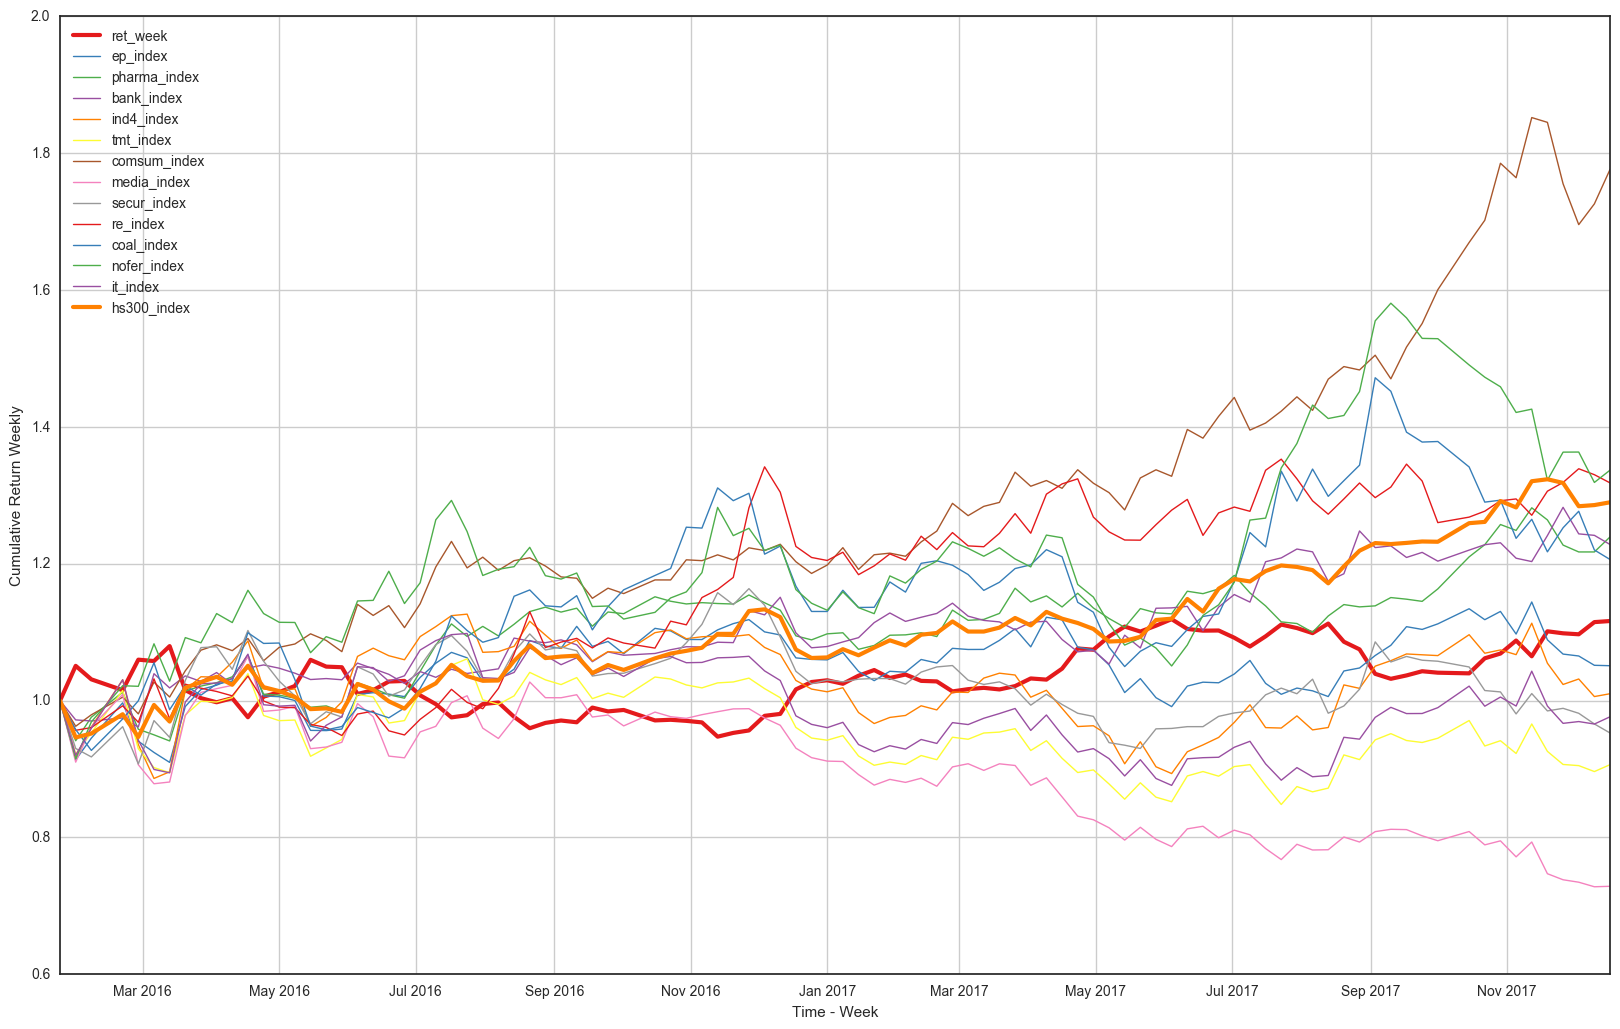

In [502]:
wRet_Comp = serRet.merge(secData_wret, left_index=True, right_index = True, how='inner')
wRet_Comp.iloc[0] = 0.0
cumRet_Comp = (wRet_Comp+1).cumprod().copy()

%matplotlib inline
sns.set_style("white")
compNum = len(cumRet_Comp.columns)
colors = sns.color_palette("Set1",compNum)
plt.figure(1,figsize = (20,20*0.618))
for i in range(compNum):
    if cumRet_Comp.columns[i] == "ret_week":
        plt.plot(cumRet_Comp.iloc[:,i], lw=3, label = cumRet_Comp.columns[i], color = colors[i])
    elif cumRet_Comp.columns[i] == "hs300_index":
        plt.plot(cumRet_Comp.iloc[:,i], lw=3, label = cumRet_Comp.columns[i], color = colors[i])
    else:
        plt.plot(cumRet_Comp.iloc[:,i], lw=1, label = cumRet_Comp.columns[i], color = colors[i])
    plt.legend(loc=2)
    plt.grid(1)
    plt.xlabel("Time - Week")
    plt.ylabel("Cumulative Return Weekly")

plt.savefig("Comparation_on_Strategy_Sector_Market.jpg")

In [503]:
cumRet_Comp.tail()

,ret_week,ep_index,pharma_index,bank_index,ind4_index,tmt_index,comsum_index,media_index,secur_index,re_index,coal_index,nofer_index,it_index,hs300_index
2017-11-19,1.101364,1.088875,1.264140,1.241261,1.054701,0.925875,1.845210,0.747061,0.984984,1.306144,1.217493,1.322204,0.992084,1.323558
2017-11-26,1.098424,1.068054,1.227354,1.282558,1.023632,0.906734,1.755434,0.738215,0.988771,1.318884,1.252655,1.363203,0.966833,1.318211
2017-12-03,1.096993,1.065275,1.217327,1.243755,1.031633,0.905049,1.695723,0.734649,0.981539,1.338931,1.276784,1.363339,0.969433,1.284146
2017-12-10,1.114791,1.051657,1.217332,1.241592,1.005974,0.896362,1.726059,0.727986,0.965940,1.330231,1.220201,1.318920,0.965817,1.285829
2017-12-17,1.116381,1.051060,1.239277,1.228235,1.010123,0.906439,1.776427,0.728673,0.952747,1.318271,1.206288,1.336872,0.976408,1.289888


# Heuristic Futher Research
<span class="mark">按照投票数量分别买进或卖出投票数份额的行业ETF，即使Down和Up投票结果相同，也能对冲风险。</span>
## Solution 2: Democratic Voting

In [452]:
def VoteSectorDirect_Democ(Tomorrow, ValidDates, ImpactLag):
    """
        param:  Tomoeeow 待预测行业行情的日期
                ImpactLag 行业影响的最大有效期限
        result: ssTomorrowWin 经过投票后获胜的行业趋势编码 
                sumValidVote 基于规则的投票有效数目
    """
    ssTomorrow = []
    TomorrowIndex = ValidDates.index(Tomorrow)
    for lag in range(1,ImpactLag+1):
        #ImpactDate = (Tomorrow + datetime.timedelta(days = -lag)).strftime("%Y-%m-%d") #02-07
        #try:
        if (TomorrowIndex - lag) >= 0:
            ImpactDate = ValidDates[TomorrowIndex - lag]
            Rules_from_ImpD = allRules[lag - 1]
            for SectState in marketDict[ImpactDate]:#各行业现实状况
                for rule in Rules_from_ImpD:#滞后lag期的规则集
                    if SectState == rule[0]:
                        ssTomorrow.append(rule[1]) 
        #except IOError:
        else:
            print "\033[31;0m Error: ImpactLag 前溯超出范围 \033";break

    uniqItems = set(ssTomorrow)
    aggDict = {}
    for i in uniqItems:
        aggDict.update({i:ssTomorrow.count(i)})#aggDict:对行业方向预测结果的投票数进行统计
        
          
    """
    ** 采用"普选"机制
    """
    sumValidVote = len(ssTomorrow)
    
    return aggDict, sumValidVote

## Main Part 3.2

In [495]:
ValidDates = sorted(marketDict.keys())
ssResultDict = {}
validVotesDict = {}
max_Valid_Impact_Lag = 4
for i in range(1,len(ValidDates)):#剔除第1个
    Tomorrow = ValidDates[i]
    if i < max_Valid_Impact_Lag: 
        """
            预测前溯响应期不足4个的，有多少取多少
        """
        ssTomorrowVote, ValidVotes = VoteSectorDirect_Democ(Tomorrow, ValidDates, i)
        #ssTomorrowVote {}
        ssResultDict.update({Tomorrow:ssTomorrowVote})
        #ssResultDict {{}}
        validVotesDict.update({Tomorrow:ValidVotes})
    else:
        ssTomorrowVote, ValidVotes = VoteSectorDirect_Democ(Tomorrow, ValidDates, max_Valid_Impact_Lag )
        ssResultDict.update({Tomorrow:ssTomorrowVote})
        validVotesDict.update({Tomorrow:ValidVotes})

In [496]:
serRetDict = {}
serRet = pd.DataFrame()
serCumRet = pd.DataFrame()

for date in sorted(ssResultDict.keys()):
    aggRet = 0.0
    avgRet = 0.0
    #distSectDirect = ssResultDict[date].keys()
    for ss in ssResultDict[date].keys():        
        if " - Down" in itemMeaning[ss]:
            ShortSect = itemMeaning[ss].rstrip(" - Down")
            aggRet -= index_ret.loc[date,ShortSect] * float(ssResultDict[date][ss])
        if " - Up" in itemMeaning[ss]:
            LongSect = itemMeaning[ss].rstrip(" - Up")
            aggRet += index_ret.loc[date,LongSect] * float(ssResultDict[date][ss])
    avgRet = aggRet/float(validVotesDict[date])
    serRetDict.update({date: avgRet})
    
serRet = pd.DataFrame.from_dict(serRetDict, orient="index")
serRet.columns = ["ret_week"]
serRet.sort_index(inplace = True)

serRet_copy = copy.deepcopy(serRet)
serRet_copy.iloc[0] = 0.0
serCumRet = (serRet_copy + 1).cumprod().copy()
serCumRet.columns = ["CumRet_Week"]

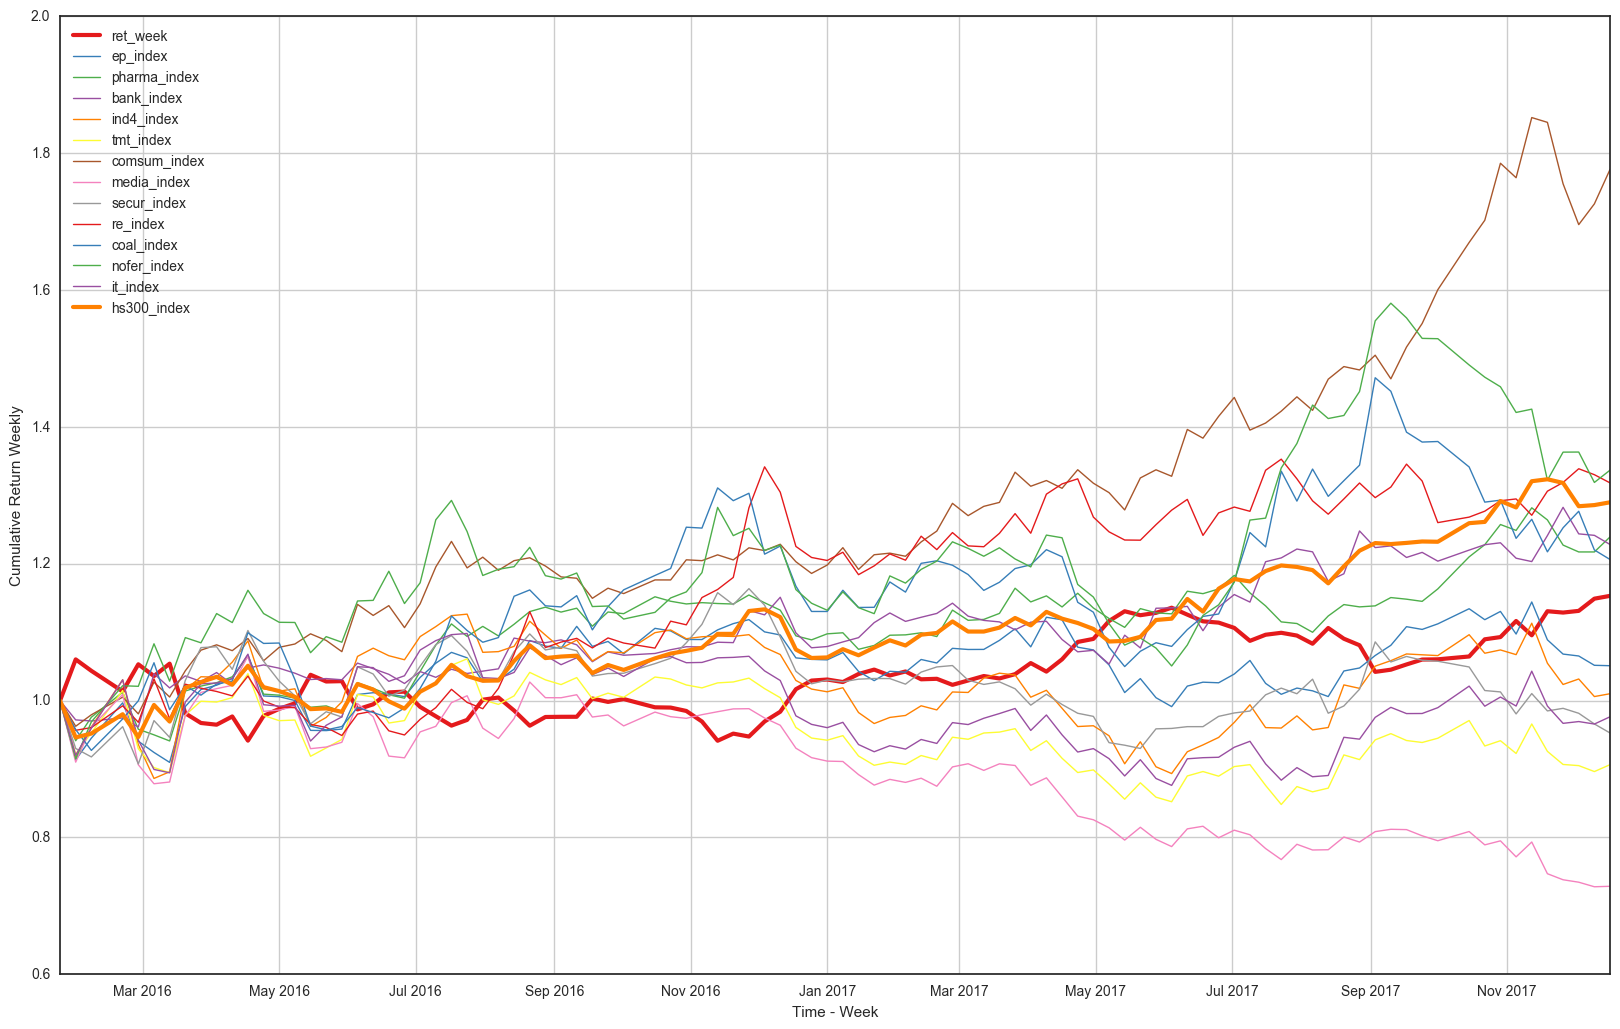

In [497]:
wRet_Comp = serRet.merge(secData_wret, left_index=True, right_index = True, how='inner')
wRet_Comp.iloc[0] = 0.0
cumRet_Comp = (wRet_Comp+1).cumprod().copy()

%matplotlib inline
sns.set_style("white")
compNum = len(cumRet_Comp.columns)
colors = sns.color_palette("Set1",compNum)
plt.figure(1,figsize = (20,20*0.618))
for i in range(compNum):
    if cumRet_Comp.columns[i] == "ret_week":
        plt.plot(cumRet_Comp.iloc[:,i], lw=3, label = cumRet_Comp.columns[i], color = colors[i])
    elif cumRet_Comp.columns[i] == "hs300_index":
        plt.plot(cumRet_Comp.iloc[:,i], lw=3, label = cumRet_Comp.columns[i], color = colors[i])
    else:
        plt.plot(cumRet_Comp.iloc[:,i], lw=1, label = cumRet_Comp.columns[i], color = colors[i])
    plt.legend(loc=2)
    plt.grid(1)
    plt.xlabel("Time - Week")
    plt.ylabel("Cumulative Return Weekly")

plt.savefig("Comparation_on_Strategy_Sector_Market_2.jpg")

In [499]:
cumRet_Comp.tail()

,ret_week,ep_index,pharma_index,bank_index,ind4_index,tmt_index,comsum_index,media_index,secur_index,re_index,coal_index,nofer_index,it_index,hs300_index
2017-11-19,1.130696,1.088875,1.264140,1.241261,1.054701,0.925875,1.845210,0.747061,0.984984,1.306144,1.217493,1.322204,0.992084,1.323558
2017-11-26,1.128736,1.068054,1.227354,1.282558,1.023632,0.906734,1.755434,0.738215,0.988771,1.318884,1.252655,1.363203,0.966833,1.318211
2017-12-03,1.131198,1.065275,1.217327,1.243755,1.031633,0.905049,1.695723,0.734649,0.981539,1.338931,1.276784,1.363339,0.969433,1.284146
2017-12-10,1.149034,1.051657,1.217332,1.241592,1.005974,0.896362,1.726059,0.727986,0.965940,1.330231,1.220201,1.318920,0.965817,1.285829
2017-12-17,1.153151,1.051060,1.239277,1.228235,1.010123,0.906439,1.776427,0.728673,0.952747,1.318271,1.206288,1.336872,0.976408,1.289888
